In [1]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

In [2]:
# 神经网络配置
max_features = 40001
maxlen = 500
batch_size = 128
embedding_dims = 50
epochs = 8
vocab_size = 40000

In [3]:

class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [2, 3, 4]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model

In [4]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt 
plt.switch_backend('agg')
%matplotlib inline

In [5]:
import sys
from collections import Counter
import numpy as np
import tensorflow.keras as kr
import os

In [6]:
def read_vocab(vocab_file):
    """读取词汇表"""
    # words = open_file(vocab_dir).read().strip().split('\n')
    with open(vocab_file,mode='r',encoding = 'utf-8') as fp:
        # 如果是py2 则每个值都转化为unicode
        words = [_.strip() for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

def encode_cate(content, words):
    """将id表示的内容转换为文字"""
    return [(words[x] if x in words else 40000) for x in content]

def encode_sentences(contents, words):
    """将id表示的内容转换为文字"""
    return [encode_cate(x,words) for x in contents]

In [7]:
age_to_id = {1:0,2:1,3:2,4:3,5:4,6:5}
gender_to_id = {1:0,2:1}
education_to_id = {1:0,2:1,3:2,4:3,5:4,6:5}

In [8]:
vocab_file_age = './processed_data/Age.txt'
vocab_file_gender = './processed_data/Gender.txt'
vocab_file_education = './processed_data/Education.txt'

In [9]:
file_proce_path = './Data/train_2.csv'

train_2 = pd.read_csv(file_proce_path,encoding='utf-8')
train_2['Query_List'] = train_2['Query_List'].apply(lambda x:x.split(' '))
train_2.head()

,Unnamed: 0,ID,Age,Gender,Education,Query_List
0,0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,"[柔和, 双沟, 女生, 中财网, 首页, 财经, 周公, 解梦, 大全, 查询, 2345..."
1,1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"[广州, 厨宝, 烤箱, 世情, 人情, 雨送, 黄昏, 花易落, 风干, 泪痕, 厦门, ..."
2,2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,"[钻石, 之泪, 耳机, 盘锦, 沈阳, 旅顺, 公交, 辽宁, 阜新, 车牌, baidu..."
3,3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,"[受欢迎, 狗狗, 排行榜, 场景, 范例, 三维, 绘图, 软件, 酸奶, 壮观, 衣服,..."
4,4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,"[干槽症, 自愈, 太太, 万岁, 舒心, 美国, 干槽症, 眼皮, 怎么回事, 麦当劳, ..."


In [10]:
Age_label = train_2[['Age','Query_List']]
Age_label = Age_label[~(Age_label['Age'] == 0)]

In [11]:
X_age = Age_label['Query_List'].values.tolist()
Y_age = Age_label['Age'].values.tolist()

In [12]:
age_words, age_word_to_id = read_vocab(vocab_file_age)

In [13]:
print(age_words[0:10])

['<PAD>', '图片', '手机', '小说', '视频', '2016', '下载', '大全', 'qq', '电影']


In [14]:
#数据打乱 
data = list(zip(X_age,Y_age))
del X_age,Y_age
random.shuffle(data)
X_age,Y_age = zip(*data)

In [15]:
datax_train, datax_test,datay_train,datay_test = train_test_split(X_age,Y_age,random_state =1)

In [16]:
x_train = encode_sentences([content for content in datax_train], age_word_to_id)
y_train = to_categorical(encode_cate(datay_train, age_to_id))
x_test = encode_sentences([content for content in datax_test], age_word_to_id)
y_test = to_categorical(encode_cate(datay_test, age_to_id))

In [17]:
print(x_train[0:20])

[[2307, 3988, 22714, 43, 3988, 4778, 5013, 40000, 40000, 40000, 1419, 40000, 451, 9354, 2, 40000, 6199, 40000, 362, 40000, 40000, 40000, 7317, 456, 1367, 40000, 1419, 6839, 8994, 2307, 123, 3695, 12307, 60, 26078, 631, 8994, 2307, 16240, 4324, 253, 10278, 36434, 13385, 40000, 31180, 24397, 21496, 40000, 2060, 3258, 1, 13385, 264, 1648, 8261, 4436, 3988, 11873, 40000, 1, 29405, 9602, 3196, 51, 20095, 5736, 12307, 20291, 25224, 2306, 18, 9390, 2828, 11791, 17940, 6534, 9986, 3940, 40000, 290, 4, 9390, 2828, 929, 1419, 280, 3258, 7624, 40000, 1689, 12742, 2950, 1762, 1528, 1025, 369, 1516, 2239, 3371, 42, 31180, 2306, 152, 3995, 346, 29, 11791, 4996, 97, 706, 25224, 7832, 2227, 1012, 7532, 452, 1995, 33520, 40000, 43, 4606, 30467, 456, 3191, 4339, 2307, 40000, 3516, 40000, 3891, 251, 8, 1419, 417, 440, 619, 1839, 31180, 26338, 40000, 2756, 2861, 11791, 345, 493, 40000, 4850, 4, 4231, 220, 128, 3988, 40000, 7317, 1450, 3988, 12025, 616, 3988, 4347, 40000, 4850, 40000, 40000, 1181, 40000, 2

In [18]:
print('对序列做padding，保证是 samples*timestep 的维度')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (73750, 500)
x_test shape: (24584, 500)
y_test shape: (24584, 6)


In [19]:
print('构建模型...')
age_model = TextCNN(maxlen, max_features, embedding_dims,class_num=6).get_model()
age_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

构建模型...


In [20]:
# 设定callbacks回调函数
age_model_file = './cnn_model.h5'
my_callbacks = [
    ModelCheckpoint(age_model_file, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

In [21]:
# fit拟合数据
history = age_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

Epoch 1/8
577/577 [==============================] - ETA: 0s - loss: 1.1682 - accuracy: 0.5329
Epoch 00001: saving model to .\cnn_model.h5
577/577 [==============================] - 50s 87ms/step - loss: 1.1682 - accuracy: 0.5329 - val_loss: 1.0749 - val_accuracy: 0.5778
Epoch 2/8
576/577 [============================>.] - ETA: 0s - loss: 0.9820 - accuracy: 0.6267
Epoch 00002: saving model to .\cnn_model.h5
577/577 [==============================] - 49s 84ms/step - loss: 0.9820 - accuracy: 0.6267 - val_loss: 1.0556 - val_accuracy: 0.5879
Epoch 3/8
576/577 [============================>.] - ETA: 0s - loss: 0.7961 - accuracy: 0.7163
Epoch 00003: saving model to .\cnn_model.h5
577/577 [==============================] - 49s 85ms/step - loss: 0.7962 - accuracy: 0.7163 - val_loss: 1.1154 - val_accuracy: 0.5772
Epoch 4/8
576/577 [============================>.] - ETA: 0s - loss: 0.5397 - accuracy: 0.8307
Epoch 00004: saving model to .\cnn_model.h5
577/577 [==============================] - 49

In [24]:
def plt_show_loss(history):
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves :CNN',fontsize=16)
    plt.show()

    
def plt_show_acc(history):
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves : CNN',fontsize=16)
    plt.show()

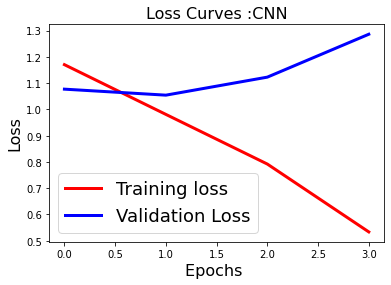

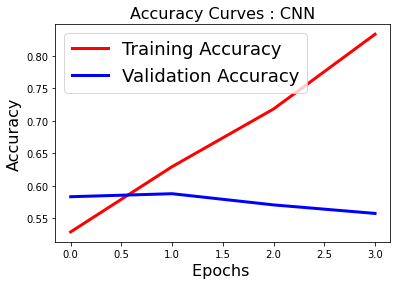

In [25]:
plt_show_loss(history)
plt_show_acc(history)